In [32]:
#import packages
import scanpy as sc
import numpy as np
import pandas as pd
import plotnine as pn
import statistics as st
pn.options.figure_size = (6,4)

In [50]:
# loading data and calculating shape of dfs

adata = sc.read_h5ad("../../clean_myeloid.h5ad")

cell_scores = pd.read_csv("../../milo_cell_scores.csv", index_col = False, header = None)

gene_loadings = pd.read_csv("../../milo_gene_loadings.csv", index_col = False, header = None).T

n_cells, n_factors = cell_scores.shape
n_genes, _ = gene_loadings.shape

<class 'numpy.ndarray'>


In [34]:
X_raw = adata.X
X_norm = adata.layers["norm_count"]
X_norm_log = adata.layers["norm_log"]

In [35]:
# calculating cutoffs (mean + 2 * stdev)

loading_cutoffs = []
for curr_factor in range(n_factors):
    curr_loadings = gene_loadings[curr_factor]
    loading_cutoffs.append( st.mean(curr_loadings) + 2 * st.stdev(curr_loadings) )

In [36]:
# plotting

'''
for curr_factor in range(n_factors):
    print(pn.ggplot(gene_loadings, pn.aes(x = 0, y = gene_loadings.loc[:,curr_factor]))
     + pn.geom_jitter(alpha = 0.7)
     + pn.geom_abline(pn.aes(intercept = loading_cutoffs[curr_factor], slope = 0), color = "blue")
     + pn.theme_bw()
     + pn.labels.ggtitle(f"Factor {curr_factor}")
     + pn.scale_x_continuous(breaks = [])
     + pn.xlab("")
     + pn.ylab("Gene loadings"))
'''

'\nfor curr_factor in range(n_factors):\n    print(pn.ggplot(gene_loadings, pn.aes(x = 0, y = gene_loadings.loc[:,curr_factor]))\n     + pn.geom_jitter(alpha = 0.7)\n     + pn.geom_abline(pn.aes(intercept = loading_cutoffs[curr_factor], slope = 0), color = "blue")\n     + pn.theme_bw()\n     + pn.labels.ggtitle(f"Factor {curr_factor}")\n     + pn.scale_x_continuous(breaks = [])\n     + pn.xlab("")\n     + pn.ylab("Gene loadings"))\n'

In [37]:
# collect important genes

# maps factor index to gene indices
top_genes = []

for curr_factor in range(n_factors):

    gene_indices = []

    for curr_gene in range(n_genes):
        if gene_loadings.iloc[curr_gene, curr_factor] > loading_cutoffs[curr_factor]:
            gene_indices.append(curr_gene)

    top_genes.append(gene_indices)

In [38]:
# gut check - how many genes per factor?
n_top_genes = []

for i in range(n_factors):
    n_top_genes.append(len(top_genes[i]))

In [39]:
# calculating variance for each gene in X

gene_variance_norm_log = [X_norm_log[:,x].var() for x in range(n_genes)]

total_variance_norm_log = sum(gene_variance_norm_log)

In [40]:
# calculate average expression for each gene in X
gene_expression_norm_log = [X_norm_log[:, x].mean() for x in range(n_genes)]

In [41]:
# try to rank factors
explained_var_norm_log = []

mean_gene_expr_norm_log = []

for curr_factor in range(n_factors):
    explained_var_norm_log.append(sum([gene_variance_norm_log[curr_gene] for curr_gene in top_genes[curr_factor]]) / total_variance_norm_log)

    mean_gene_expr_norm_log.append(st.mean([gene_expression_norm_log[curr_gene] for curr_gene in top_genes[curr_factor]]))

factor_scores = pd.DataFrame({'factor' : list(range(n_factors)),
                              'explained_variance_norm_log' : explained_var_norm_log,
                              'mean_gene_expression_norm_log' : mean_gene_expr_norm_log})

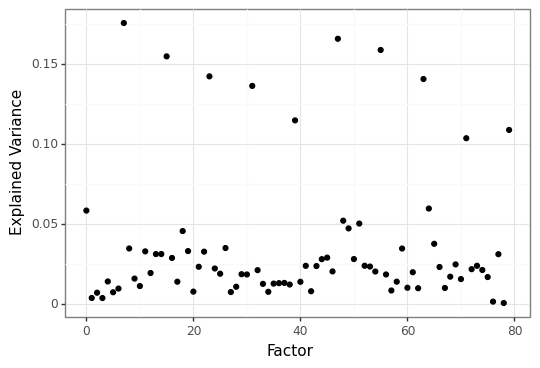

<ggplot: (172632720273)>

In [42]:
(pn.ggplot(factor_scores)
 + pn.aes(x = 'factor', y = 'explained_variance_norm_log')
 + pn.xlab("Factor")
 + pn.ylab("Explained Variance")
 + pn.geom_point()
 + pn.theme_bw())

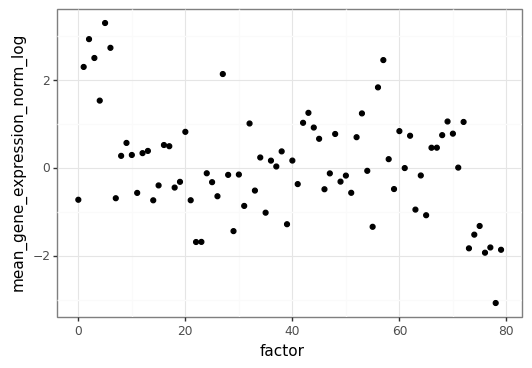

<ggplot: (107738268552)>

In [ ]:
(pn.ggplot(factor_scores)
 + pn.aes(x = 'factor', y = 'mean_gene_expression_norm_log')
 + pn.geom_point()
 + pn.theme_bw())

In [ ]:
dummy_adata = sc.AnnData(adata.layers['norm_log'])
sc.pp.highly_variable_genes(dummy_adata, flavor = 'cell_ranger')

adata.var['highly_variable'] = dummy_adata.var['highly_variable']
adata.var['norm_dispersions'] = dummy_adata.var['dispersions_norm']
adata.var['dispersions'] = dummy_adata.var['dispersions']
adata.var['means'] = dummy_adata.var['means']

C:\Users\Brian\AppData\Local\Temp\ipykernel_5232\3662494249.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


C:\Users\Brian\AppData\Local\Programs\Python\Python310\lib\site-packages\plotnine\layer.py:411: PlotnineWarning: geom_point : Removed 31 rows containing missing values.


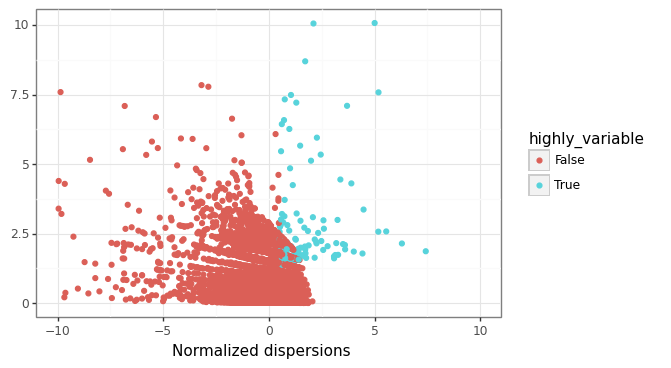

<ggplot: (107724576829)>

In [ ]:
(pn.ggplot()
 + pn.aes(x = dummy_adata.var['dispersions_norm'], y = gene_variance_norm_log, color = dummy_adata.var['highly_variable'])
 + pn.xlab("Normalized dispersions")
 + pn.scales.xlim((-10, 10))
 + pn.geom_point()
 + pn.theme_bw())

In [ ]:
mean_disp = []
sum_disp = []

for curr_factor in range(n_factors):
    mean_disp.append(st.mean([dummy_adata.var['dispersions_norm'][curr_gene] for curr_gene in top_genes[curr_factor]]))
    sum_disp.append(sum([dummy_adata.var['dispersions_norm'][curr_gene] for curr_gene in top_genes[curr_factor]]))

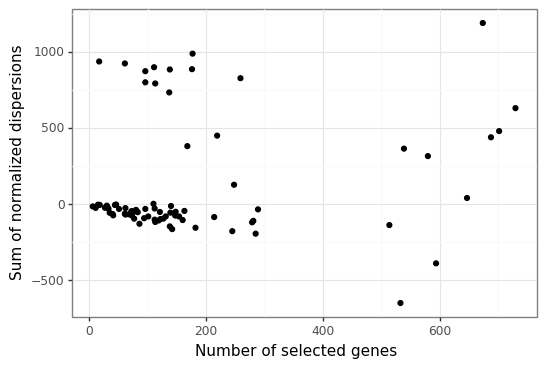

<ggplot: (107724680081)>

In [ ]:
(pn.ggplot(factor_scores)
 + pn.aes(x = 'n_top_genes', y = sum_disp)
 + pn.xlab("Number of selected genes")
 + pn.ylab("Sum of normalized dispersions")
 + pn.geom_point()
 + pn.theme_bw())

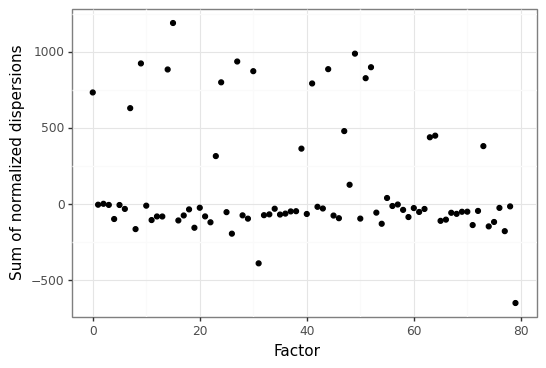

<ggplot: (107723732854)>

In [ ]:
(pn.ggplot(factor_scores)
 + pn.aes(x = "factor", y = sum_disp)
 + pn.xlab("Factor")
 + pn.ylab("Sum of normalized dispersions")
 + pn.geom_point()
 + pn.theme_bw())

In [47]:
dummy_adata = sc.AnnData(cell_scores.to_numpy())
sc.pp.highly_variable_genes(dummy_adata, flavor = 'cell_ranger')

factor_dispersions = dummy_adata.var["dispersions_norm"].values

C:\Users\Brian\AppData\Local\Temp\ipykernel_17624\3102497053.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [ ]:
dummy_adata = sc.AnnData(cell_scores, obs = adata.obs)
sc.pp.highly_variable_genes(dummy_adata, flavor = 'cell_ranger')

C:\Users\brian\AppData\Local\Temp\ipykernel_17580\62898735.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
C:\Users\brian\AppData\Roaming\Python\Python39\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.


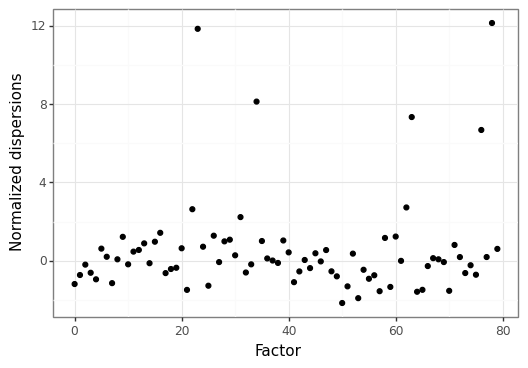

<ggplot: (172690921992)>

In [48]:
(pn.ggplot(dummy_adata.var)
 + pn.aes(x = list(range(n_factors)), y = "dispersions_norm")
 + pn.xlab("Factor")
 + pn.ylab("Normalized dispersions")
 + pn.geom_point()
 + pn.theme_bw())